# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://docs.langchain.com/oss/python/langgraph/streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

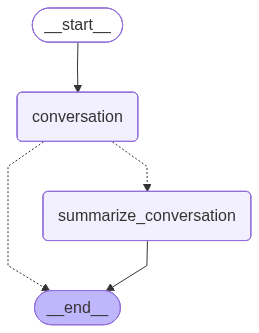

In [16]:
from IPython.display import Image, display
from typing import Literal

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://docs.langchain.com/oss/python/langgraph/streaming#supported-stream-modes).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://docs.langchain.com/oss/python/langgraph/streaming#stream-graph-state) for graph state.
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm pytholic")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi there, Pytholic! 👋\n\nThat's a fantastic self-description – I love it! You're definitely in good company here. Python has a way of captivating us all with its versatility, readability, and vast ecosystem.\n\nSo, what kind of Python adventures are you currently on, or what brings you here today? Are you diving into data science, web development, automation, machine learning, or something else entirely?\n\nHow can I help you explore your Pytholic tendencies further?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c425e-1486-7b81-8d57-3f0edf5568ee-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 9, 'output_tokens': 1168, 'total_tokens': 1177, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1065}})}}


Let's now just print the state update.

In [4]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm pytholic")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Ah, welcome back, Pytholic! 👋

It's great to hear from you again! That strong Python identity is definitely shining through.

So, tell me, what's on your mind today? Are you looking to:

*   **Discuss a specific Python problem or project?**
*   **Learn about a new Python library or concept?**
*   **Share something cool you've built with Python?**
*   **Just chat about the awesomeness of Python in general?**

I'm ready when you are! Let's dive into some Python goodness.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm pytholic")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm pytholic
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm pytholic
================================== Ai Message ==================================

Haha, I love that! Welcome, fellow Pytholic! That's a fantastic way to describe a serious passion for Python.

So, what's on your mind today in the world of Python? Are you working on a cool project, exploring a new library, wrestling with a tricky problem, or just want to chat about its awesomeness?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://docs.langchain.com/oss/python/langchain/models#advanced-streaming-topics:streaming-events), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream.

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='The **San Francisco 49ers** are one of the most storied and successful franchises in', additional_kwargs={}, response_metadata={'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c4261-c554-7f70-9d63-6ca7e51780d0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 11, 'output_tokens': 1295, 'total_tokens': 1306, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1276}}, tool_call_chunks=[])}
{'chunk': AIMessageChunk(content=" the National Football League (NFL). Here's a breakdown of what makes them a legendary team:\n\n### Basic Information\n\n*   **Location:** San Francisco Bay Area (their stadium is in Santa Clara, California).\n*   **Division", additional_kwargs={}, response_metadata={'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c4261-c554-7f70-9d63-6ca7e51780d0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 0, 'output_token_deta

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

The San Francisco 49ers are one of the most storied and successful franchises in NFL history, known for their rich tradition, iconic players, and multiple Super Bowl championships.

Here's a breakdown of the team:

1.|  **Founding and Name Origin:**
    *   **Founded:** 1946, as a charter member of the All-America Football Conference (AAFC). They joined the NFL in 1950 when the AAFC merged| with the NFL.
    *   **Name:** "49ers" refers to the prospectors who arrived in Northern California during the 1849 Gold Rush.

2.  **Home Stadium:**
    *   **Current|:** Levi's Stadium in Santa Clara, California (opened 2014).
    *   **Previous Iconic Stadium:** Candlestick Park (1971-2013), which was famous for its often| windy and chilly conditions.

3.  **Team Colors & Logo:**
    *   **Colors:** Scarlet (red), Gold, and White.
    *   **Logo:** A stylized "SF" in gold with a red outline,| often placed within a white oval.

4.  **Championships & Dynasties:**
    *   The 49ers have won **5 Sup

### Streaming with LangGraph API

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API  [supports editing graph state](https://docs.langchain.com/langsmith/add-human-in-the-loop). 

In [9]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [10]:
assistants

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2026-02-09T12:38:53.790947+00:00',
  'updated_at': '2026-02-09T12:38:53.790947+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2026-02-09T12:34:34.111183+00:00',
  'updated_at': '2026-02-09T12:34:34.111183+00:00',
  'version': 1,
  'description': None}]

Let's [stream `values`](https://docs.langchain.com/oss/python/langgraph/streaming#stream-graph-state), like before.

In [11]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019c426a-d938-7e32-b4d7-63c92bf9a285', 'attempt': 1}, id=None)
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '316cc26c-bf96-42aa-874a-d5022c5cbe91'}]}, id=None)
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '316cc26c-bf96-42aa-874a-d5022c5cbe91'}, {'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"b": 3, "a": 2}'}, '__gemini_function_call_thought_signatures__': {'3840d0a5-717f-41ad-9fe1-d52535481725': 'CoUCAb4+9vs+zibWQQVKBur1IGe5wxXY/PPTUUnTl7jPBEHVgp4Ocz9X9FNXfsMSnqyFch6ofBNLIknURFO4uZHuIbEUvx5TXoORpTQ8YMQxhXEFWddMMu1Pr1fXo1YnsIEOfEpszPJ505rZMD3U4Wq/oatZp9aAxjNQLRdkb5Qby4YBmrhCun9AWASDNA8YLoDv4MolwGVLrioqg2swarDKB7eLERYWO+BEiyfpsF3gbnIpjzR3DpZkFAhiR+XNDqtJUWgg22trw

The streamed objects have: 

* `event`: Type
* `data`: State

In [12]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='c6e378a9-17e5-473c-915a-dae0a01ad985'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 169, 'output_tokens': 78, 'total_tokens': 247, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 60}}, 'function_call': {'name': 'multiply', 'arguments': '{"b": 3, "a": 2}'}, '__gemini_function_call_thought_signatures__': {'71e83700-8f1d-4d76-914e-3135cb257325': 'CvwBAb4+9vupxqc3dawy+/2ydJAYozi5jbRtTuwczE0vFH7oAWTIypOwUFSXTDI4qk95S/EUI3f9awfQ/ZKu+X5+tm7mgQoa1U0RpK0LSBu9y28g3+sEUENFtg86KK/dLBHP7QKx2lWEQ6rGcQ22oBdYbvunSIIdNAnQwU90Sv6+gvbFB00468viNwO39A7y4zo2A+IuboMhz2gtxs/GYrxWx/ZmWcrVG4AHGLQXbC+B+0rrUapj9kk0WtUaVO2LFHOq5P7mIU97Xp+5Ek8WX3wZzzi7U7inc1qFGQcKuHulCq22JByl0EQGDhDooXNq875SWjFyFNqlncZxIBr7'}} response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'} id='lc_run--019c426b-8f00-

There are some new streaming mode that are only supported via the API.

For example, we can  [use `messages` mode](https://docs.langchain.com/oss/python/langgraph/streaming#supported-stream-modes) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

<!--You can dig further into the types [~here~](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages) [here](https://docs.langchain.com/oss/python/langgraph/concepts/langgraph_server). -->

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [17]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3. Then divide the answer by 2.")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata and response_metadata.get("finish_reason"):
                    print(f"Response Metadata: Finish Reason - {response_metadata['finish_reason']}")                    
        print("-" * 50)

Metadata: Run ID - 019c4271-6de2-7690-be71-2d29f70a40bd
--------------------------------------------------
Tool Calls:
Tool Call ID: 4f297797-b156-454c-8343-ab02cc20689c, Function: multiply, Arguments: {'b': 3, 'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: 4f297797-b156-454c-8343-ab02cc20689c, Function: multiply, Arguments: {'b': 3, 'a': 2}
Response Metadata: Finish Reason - STOP
--------------------------------------------------
Tool Calls:
Tool Call ID: 4f297797-b156-454c-8343-ab02cc20689c, Function: multiply, Arguments: {'b': 3, 'a': 2}
Response Metadata: Finish Reason - STOP
--------------------------------------------------
Tool Calls:
Tool Call ID: 68eeaee4-16d1-4e99-86a2-2f38acae0832, Function: divide, Arguments: {'a': 6, 'b': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: 68eeaee4-16d1-4e99-86a2-2f38acae0832, Function: divide, Arguments: {'a': 6, 'b': 2}
Response Metadata: Finish Reason - STOP
-------------

Trace: https://smith.langchain.com/public/483a45d3-b7f8-4405-9db7-4e57f96b0743/r